In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import network as nw
import road as rd
import traffic_lights as tl
import torch
import FV_schemes as fv
import junction as jn

### Duty to give way crossing connections

We visualize how adding duty to give way for crossing connections impact the flow of traffic in a simple 2-2 junction. 
We assume that roads 1 and 3 are horizontal roads, and that roads 2 and 4 are vertical roads. We further assume that all traffic from road 1 goes to road 3, and that all the traffic from road 2 goes to road 4. Finally, we assume that traffic from road 2 has right of way.

The distribution matrix takes the form
$$
A = 
\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}.
$$

We want to compare how different adding duty to give way impacts the flow of traffic of traffic through the junction for different choices of densities on the roads.

In [31]:
# Configuration of the network
distribution = [[1.0, 0.0], [0.0, 1.0]]
priorities = [[1, 1], [2, 2]]
crossing_connections =  [[[], []],
                        [[], [(0,0)]]]
L = 50
N = 5
in_dens_1 = 0.7
out_dens_1 = 0.2
in_dens_2 = 0.4
out_dens_2 = 0.1

In [54]:
# Creating the network
road1 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (-1, 0), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * in_dens_1, inflow = 0.3, id = "1_fw")
road2 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 1), right_pos = (0, 0),
                initial = lambda x: torch.ones_like(x) * out_dens_1, inflow = 0.05, id = "2_fw")
road3 = rd.Road(2, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (1, 0),
                initial = lambda x: torch.ones_like(x) * in_dens_2, inflow = 0.0, id = "3_fw")
road4 = rd.Road(1, L, N, torch.tensor([50.0], requires_grad=True), [], left_pos = (0, 0), right_pos = (0, -1),
                initial = lambda x: torch.ones_like(x) * out_dens_2, inflow = 0.0, id = "4_fw")

entering = [0,2]
leaving = [1, 3]

junction = jn.Junction([road1, road2, road3, road4], entering, leaving, distribution, trafficlights=[],
                       coupled_trafficlights = [], duty_to_gw = True, priorities = priorities,
                       crossing_connections = crossing_connections)
T = 100
network = nw.RoadNetwork([road1, road2, road3, road4], [junction], T)
t = torch.tensor(0.0)
for road in network.roads:
    road.update_index(t)

In [55]:
# network.roads[2].rho = torch.ones_like(network.roads[2].rho) * 0.01

# print(network.roads[2].gamma[0])
# print(network.roads[2].demand())
# print(network.roads[2].rho)
# gamma = torch.tensor(0.2778)
# print(fv.D(torch.tensor(0.4), gamma))

# #0.0667

In [70]:
# We now want to calculate the flux through the junction:
in_fluxes = []
in_fluxes_wo = []

densities = torch.linspace(0,0.55,100)
network.roads[2].rho = torch.ones_like(network.roads[2].rho) * 0.4
# print(f"Densities on roads: {[road.rho[-1] for road in network.roads]}")
# print(f"Demands of roads: {[road.demand() for road in network.roads]}")
# print(f"Gamma of roads: {network.roads[2].gamma}")
for rho in densities:
    network.roads[0].rho = torch.ones_like(network.roads[0].rho) * rho

    # With right of way:
    fluxes_in, fluxes_out = junction.divide_flux_right_of_way(t)

    # Without right of way:
    fluxes_in_no_row, fluxes_out_no_row = junction.divide_flux(t)
    # print(f"Density on road 1: {rho}:")
    # print(f"Flux 1-3 with/without right of way: {fluxes_in[0].detach():.{4}f}/{fluxes_in_no_row[0].detach():.{4}f}")
    # print(f"Flux 2-4 with/without right of way: {fluxes_in[1].detach():.{6}f}/{fluxes_in_no_row[1].detach():.{6}f}\n")
    in_fluxes.append(fluxes_in[1].detach())
    in_fluxes_wo.append(fluxes_in_no_row[1].detach())

in_fluxes_2 = []
in_fluxes_wo_2 = []
network.roads[2].rho = torch.ones_like(network.roads[2].rho) * 0.1
# print(f"Densities on roads: {[road.rho[0] for road in network.roads]}")
# print(f"Demands of roads: {[road.demand() for road in network.roads]}")

for rho in densities:
    network.roads[0].rho = torch.ones_like(network.roads[0].rho) * rho
    # With right of way:
    fluxes_in, fluxes_out = junction.divide_flux_right_of_way(t)

    # Without right of way:
    fluxes_in_no_row, fluxes_out_no_row = junction.divide_flux(t)
    # print(f"Density on road 1: {rho}:")
    # print(f"Flux 1-3 with/without right of way: {fluxes_in[0].detach():.{4}f}/{fluxes_in_no_row[0].detach():.{4}f}")
    # print(f"Flux 2-4 with/without right of way: {fluxes_in[1].detach():.{6}f}/{fluxes_in_no_row[1].detach():.{6}f}\n")
    in_fluxes_2.append(fluxes_in[1].detach())
    in_fluxes_wo_2.append(fluxes_in_no_row[1].detach())

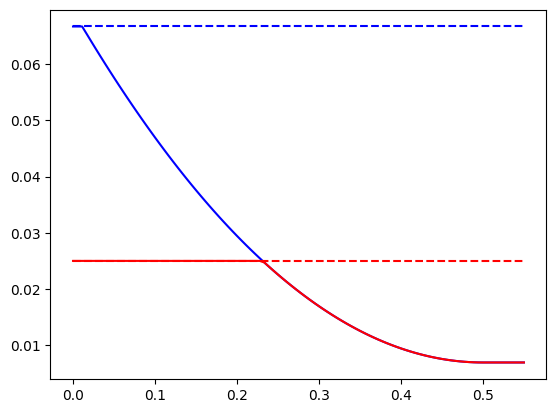

In [71]:
plt.plot(np.array(densities), in_fluxes, 'b')
plt.plot(np.array(densities), in_fluxes_wo, 'b--')
plt.plot(np.array(densities), in_fluxes_2, 'r')
plt.plot(np.array(densities), in_fluxes_wo_2, 'r--')
plt.show()


#### Priority parameter depending on density

We now want to investigate how a varying priority parameter impacts the flow of traffic through a junction.

What is the best way to visualize this?

One idea is to look at a 2-1 junction for some different values of the flux. 
Then ...